In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Data Encoding and Scaling
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, RobustScaler, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn import set_config

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

In [4]:
warnings.filterwarnings('ignore')

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [6]:
# df = pd.read_csv('extracted_data1.csv')
df = pd.read_csv('test_data.csv')

In [7]:
df.shape

(6116, 32)

In [8]:
df.drop(['credit_amount',
         'subscription_type_y'], axis=1, inplace=True)

In [9]:
''' Filled all the null values before encoding the data '''

for col in df.columns:
    if df[col].dtype == np.int64:
        df[col].fillna(0, inplace=True)
    elif df[col].dtype == np.float64:
        df[col].fillna(0.0, inplace=True)
    elif df[col].dtype == object:
        unique_vals = df[col].dropna().unique()
        if set(unique_vals).issubset({'Yes', 'No'}):
            df[col].fillna('No', inplace=True)
        else:
            df[col].fillna('Unknown', inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6116 entries, 0 to 6115
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   jobma_catcher_id               6116 non-null   int64  
 1   org_type                       6116 non-null   float64
 2   jobma_catcher_industry         6116 non-null   object 
 3   jobma_catcher_type             6116 non-null   int64  
 4   is_premium                     6116 non-null   float64
 5   jobma_catcher_sub_accounts     6116 non-null   int64  
 6   jobma_catcher_is_deleted       6116 non-null   object 
 7   jobma_verified                 6116 non-null   int64  
 8   subscription_status            6116 non-null   int64  
 9   interview_rate                 6116 non-null   float64
 10  live_interview_credit          6116 non-null   float64
 11  pre_recorded_credit            6116 non-null   float64
 12  credit_value                   6116 non-null   i

In [11]:
''' This Function is to fill all missing values (if col is int then 0, if col is float then 0.0 and if col is object then 'Unkmown') '''

def fill_missing_values(df):
    df = df.copy()
    if df[col].dtype == np.int64:
        df[col].fillna(0, inplace=True)
    elif df[col].dtype == np.float64:
        df[col].fillna(0.0, inplace=True)
    elif df[col].dtype == object:
        unique_vals = df[col].dropna().unique()
        if set(unique_vals).issubset({'Yes', 'No'}):
            df[col].fillna('No', inplace=True)
        else:
            df[col].fillna('Unknown', inplace=True)
    return df

# Data Encoding

In [13]:
label_encoders = {}
label_col = ['jobma_catcher_industry', 'org_type']

def label_encoder(df):
    for col in label_col:
        if col in df.columns:
            if df[col].dtype == object or df[col].dtype.name == 'category':
                le_col = LabelEncoder()
                df[col] = le_col.fit_transform(df[col].astype(str))
                label_encoders = le_col

    return df

In [14]:
def ordinal_encoder(df):
    ordinal_col = ['jobma_catcher_is_deleted', 'company_size', 'plan_type', 'is_unlimited']
    
    is_deleted_order = ['Yes', 'No']
    company_size_order = ['Unknown', '1-25', '26-100', '101-500', '500-1000', 'More than 1000']
    plan_type_order = ['Unknown', 'No', 'Yes']
    is_unlimited_order = ['Unknown', 'No', 'Yes']

    ordinal_order = [is_deleted_order, company_size_order, plan_type_order, is_unlimited_order]

    ordinal = OrdinalEncoder(categories=ordinal_order)
    encoded = ordinal.fit_transform(df[ordinal_col].astype(str))
    encoded_df = pd.DataFrame(encoded, columns=[f'{col}_ord' for col in ordinal_col], index=df.index)

    df.drop(columns=ordinal_col, inplace=True)

    df = pd.concat([df, encoded_df], axis=1)
    
    return df

# Log Transformation

In [16]:
log_cols = [
    'wallet_amount',
    'subscription_amount',
    'number_of_invitations',
    'job_posted',
    'number_of_kits',
    'interview_question',
    'pre_recorded_credit',
    'live_interview_credit'
]

In [17]:
def log_transform(df):
    df = df.copy()
    for col in log_cols:
        if col in df.columns:
            # fill NaNs
            df[col] = df[col].fillna(0)
            # if a number is less than zero, turn it into zero;
            df[col] = df[col].clip(lower=0)
            # safe log1p
            df[col] = np.log1p(df[col])
    return df

# Pipeline

In [19]:
pipeline = Pipeline([
    ('fill_missing_values', FunctionTransformer(fill_missing_values, validate=False)),
    ('label_encoder', FunctionTransformer(label_encoder, validate=False)),
    ('ordinal_encoder', FunctionTransformer(ordinal_encoder, validate=False)),
    ('log_transformation', FunctionTransformer(log_transform, validate=False)), # log transforms the col with outliers
    ('scaler', StandardScaler()), # Needs attention to improve model
    # ('pca', PCA(n_components=0.97))
])

In [20]:
''' Visualizing the Pipeline '''
set_config(display='diagram')
pipeline

Pipeline(steps=[('fill_missing_values',
                 FunctionTransformer(func=<function fill_missing_values at 0x0000029397DA8400>)),
                ('label_encoder',
                 FunctionTransformer(func=<function label_encoder at 0x0000029397DA84A0>)),
                ('ordinal_encoder',
                 FunctionTransformer(func=<function ordinal_encoder at 0x0000029397DA94E0>)),
                ('log_transformation',
                 FunctionTransformer(func=<function log_transform at 0x0000029397DA8720>)),
                ('scaler', StandardScaler())])

# Fit Pipeline

In [22]:
X = df

In [23]:
X_transformed = pipeline.fit_transform(X)

In [24]:
type(X)

pandas.core.frame.DataFrame

In [25]:
type(X_transformed)

numpy.ndarray

In [26]:
features_names = df.columns

In [27]:
X_df = pd.DataFrame(X_transformed, columns=features_names)

In [28]:
X_df.columns

Index(['jobma_catcher_id', 'org_type', 'jobma_catcher_industry',
       'jobma_catcher_type', 'is_premium', 'jobma_catcher_sub_accounts',
       'jobma_catcher_is_deleted', 'jobma_verified', 'subscription_status',
       'interview_rate', 'live_interview_credit', 'pre_recorded_credit',
       'credit_value', 'interview_cost_type', 'subscription_type_x',
       'jobma_support_rtc', 'interview_question', 'video_recording_suppport',
       'sing_up_canditate_after_apply', 'currency', 'company_size',
       'wallet_amount', 'plan_type', 'is_unlimited', 'premium_storage',
       'subscription_amount', 'number_of_subscriptions',
       'number_of_invitations', 'job_posted', 'number_of_kits'],
      dtype='object')

In [29]:
X_df.head(5)

,jobma_catcher_id,org_type,jobma_catcher_industry,jobma_catcher_type,is_premium,jobma_catcher_sub_accounts,jobma_catcher_is_deleted,jobma_verified,subscription_status,interview_rate,...,company_size,wallet_amount,plan_type,is_unlimited,premium_storage,subscription_amount,number_of_subscriptions,number_of_invitations,job_posted,number_of_kits
0,-1.801958,-0.324121,0.485709,0.66236,-0.438409,0.0,0.018086,-1.092955,0.0,0.130641,...,0.0,1.136717,-0.176975,1.321832,0.853812,1.585420,0.0,-0.989747,-0.711360,2.504455
1,-1.673482,-0.324121,-1.162534,0.66236,-0.438409,0.0,0.018086,0.904210,0.0,0.130641,...,0.0,-0.234210,-0.176975,-0.372727,-0.383732,-0.385895,0.0,-0.111057,1.405758,-0.399288
2,-1.672561,-0.324121,0.140979,0.66236,-0.438409,0.0,0.018086,0.904210,0.0,0.130641,...,0.0,-0.042089,-0.176975,-0.372727,-0.383732,-0.385895,0.0,0.767632,1.405758,-0.399288
3,-1.672101,-0.324121,-1.539583,0.66236,-0.438409,0.0,0.018086,-1.092955,0.0,0.130641,...,0.0,1.139948,0.472322,-0.372727,0.853812,-0.385895,0.0,-0.111057,1.405758,-0.399288
4,-1.671640,-0.324121,-1.474946,0.66236,-0.438409,0.0,0.018086,0.904210,0.0,0.130641,...,0.0,1.078241,-0.176975,-0.372727,0.853812,-0.385895,0.0,-0.111057,1.405758,-0.399288


In [30]:
X_df.shape

(6116, 30)

In [31]:
X_df.describe().T

,count,mean,std,min,25%,50%,75%,max
jobma_catcher_id,6116.0,-1.487074e-16,1.000082,-1.801958,-0.845184,-0.033923,0.723001,1.826670
org_type,6116.0,9.294215e-18,1.000082,-0.324121,-0.324121,-0.324121,-0.324121,4.558455
jobma_catcher_industry,6116.0,-7.725816e-17,1.000082,-2.078224,-0.882440,0.302571,1.153624,1.175170
jobma_catcher_type,6116.0,1.115306e-16,1.000082,-1.509754,-1.509754,0.662360,0.662360,0.662360
is_premium,6116.0,0.000000e+00,1.000082,-0.438409,-0.438409,-0.438409,-0.438409,2.280973
jobma_catcher_sub_accounts,6116.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
jobma_catcher_is_deleted,6116.0,2.681381e-15,1.000082,-55.290144,0.018086,0.018086,0.018086,0.018086
jobma_verified,6116.0,2.230612e-16,1.000082,-3.090120,-1.092955,0.904210,0.904210,0.904210
subscription_status,6116.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
interview_rate,6116.0,-3.392388e-16,1.000082,-5.733589,0.130641,0.130641,0.130641,15.289454


In [32]:
df['is_unlimited'].unique()

array(['Yes', 'No'], dtype=object)

In [33]:
X_tensor = torch.tensor(X_transformed, dtype=torch.float32).to(device)

In [34]:
type(X_tensor)

torch.Tensor

In [35]:
len(X_tensor)

6116

# Dataset Class

In [37]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [38]:
X_data = CustomDataset(X_tensor)

# DataLoader

In [40]:
BATCH_SIZE = 8

In [41]:
dataloader = DataLoader(X_data, batch_size=BATCH_SIZE, shuffle=True)

In [42]:
len(X_data)

6116

In [43]:
len(dataloader)

765

# Autoencoder

In [45]:
class AutoEncoder(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        ''' Encoder (Compression) '''
        # Shrinks job data into a small hidden representation (like a summary).
        self.encoder = nn.Sequential(
            nn.Linear(input_shape, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )

        ''' Decoder (Reconstruction) '''
        # Tries to rebuild the original job data from that compressed version.
        self.decoder = nn.Sequential(
            nn.Linear(32,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128, input_shape)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

**FLOW 1**

Model's encoder(embeddings) ----->  DEC's Input1

In [47]:
X_df.shape[1]

30

In [48]:
''' Initializing the model '''
input_shape = X_df.shape[1]

model_1 = AutoEncoder(input_shape)
model_1.to(device)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=30, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=30, bias=True)
  )
)

In [49]:
''' Important Parameters '''

learning_rate = 0.001
epochs = 20

In [50]:
''' Loss Function and Optimizer '''

cosine_loss_function = nn.CosineEmbeddingLoss()
mse_loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate)

In [51]:
torch.manual_seed(42)

model_1.train()
model_1.to(device)

for epoch in range(epochs):
    epoch_total_loss = 0

    for batch_X in dataloader:
        batch_X = batch_X.to(device)

        # Forward pass
        encoded, decoded = model_1(batch_X)

        # Reconstruction Loss
        mse_loss = mse_loss_function(decoded, batch_X)

        # Similarity Loss using randomly shuffled batch
        # Get how many samples are in this batch
        batch_size = encoded.shape[0]
        # Create target labels (1 means we want vectors to be similar)
        target_labels = torch.ones(batch_size, device=device)

        # Shuffle the encoded vectors randomly
        permuted_indices = torch.randperm(batch_size, device=device)
        encoded_shuffled = encoded[permuted_indices]

        # Calculate Cosine Embedding Loss on original vs shuffled
        cosine_loss = cosine_loss_function(encoded, encoded_shuffled, target_labels)

        # Total Loss
        total_loss = mse_loss + cosine_loss

        # Backpropagation
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        epoch_total_loss += total_loss.item()

    # Average loss over all batches in the epoch
    training_loss = epoch_total_loss / len(dataloader)
    print(f'Epoch {epoch+1}/{epochs} | Training Loss: {training_loss:.5f}')


Epoch 1/20 | Training Loss: 0.52693
Epoch 2/20 | Training Loss: 0.31145
Epoch 3/20 | Training Loss: 0.24965
Epoch 4/20 | Training Loss: 0.21513
Epoch 5/20 | Training Loss: 0.19061
Epoch 6/20 | Training Loss: 0.17766
Epoch 7/20 | Training Loss: 0.14124
Epoch 8/20 | Training Loss: 0.13440
Epoch 9/20 | Training Loss: 0.10422
Epoch 10/20 | Training Loss: 0.09352
Epoch 11/20 | Training Loss: 0.08562
Epoch 12/20 | Training Loss: 0.07397
Epoch 13/20 | Training Loss: 0.10079
Epoch 14/20 | Training Loss: 0.07406
Epoch 15/20 | Training Loss: 0.07738
Epoch 16/20 | Training Loss: 0.04682
Epoch 17/20 | Training Loss: 0.04511
Epoch 18/20 | Training Loss: 0.06547
Epoch 19/20 | Training Loss: 0.05162
Epoch 20/20 | Training Loss: 0.06050


# Clustering

In [53]:
model_1.eval()

with torch.no_grad():
    encoder, _ = model_1(X_tensor)

latent_np = encoder.cpu().numpy()

In [54]:
wcss = []
silhouette_scores = []
k_range = range(2,11)

In [55]:
torch.manual_seed(42)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(latent_np)
    
    wcss.append(kmeans.inertia_)  # Inertia = WCSS
    silhouette_scores.append(silhouette_score(latent_np, labels))

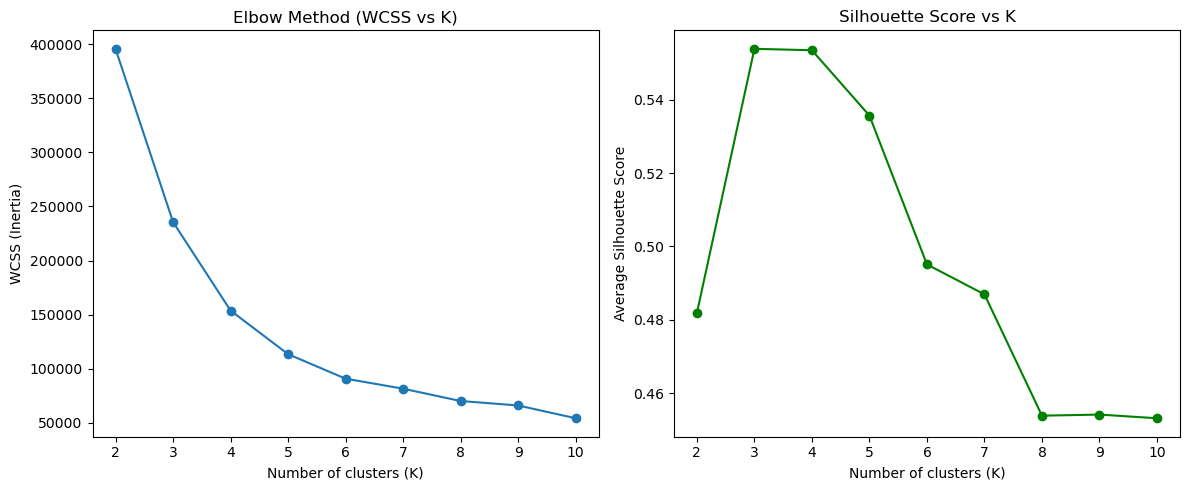

In [56]:
''' Elbow Rule to decide the number of clusters '''
torch.manual_seed(42)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method (WCSS vs K)')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS (Inertia)')

# Step 5: Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', color='green')
plt.title('Silhouette Score vs K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Average Silhouette Score')

plt.tight_layout()
plt.show()

In [57]:
#Initialising KMeans
kmeans = KMeans(n_clusters=3, n_init=50)
cluster_ids = kmeans.fit_predict(latent_np)
cluster_centers = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32).to(device)

**FLOW 2**

KMeans Cluster_Centers(Centroids) ----->  DEC's Input2

In [59]:
# Deep Embedding Clusturing Model
class DEC(nn.Module):
    def __init__(self, encoder, cluster_centers):
        super(DEC, self).__init__()
        self.encoder = encoder
        self.cluster_centers = nn.Parameter(cluster_centers)

    def forward(self, x):
        z = self.encoder(x)
        q = 1.0 / (1.0 + torch.sum((z.unsqueeze(1) - self.cluster_centers)**2, dim=2))
        q = q.pow((1 + 1) / 2.0)
        q = (q.t() / torch.sum(q, dim=1)).t()
        return q, z

def target_distribution(q):
    weight = q**2 / q.sum(0)
    return (weight.t() / weight.sum(1)).t()  

In [60]:
''' Initializing DEC Model '''
dec = DEC(model_1.encoder, cluster_centers.clone()).to(device)

In [61]:
''' Loss Function and Optimizer '''

kl_loss = nn.KLDivLoss(reduction='batchmean')
optimizer = torch.optim.Adam(dec.parameters(), lr=1e-4)

In [62]:
''' Training Loop '''
torch.manual_seed(42)
dec.train()
num_epochs = 50

for epoch in range(num_epochs):
    for batch in dataloader:
        x = batch.to(device)

        # Forward pass
        q, z = dec(x)

        # Target distribution
        p = target_distribution(q)

        # Compute loss
        loss = kl_loss(q.log(), p)

        # Backpropogation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/50, Loss: 0.0702
Epoch 2/50, Loss: 0.0214
Epoch 3/50, Loss: 0.0218
Epoch 4/50, Loss: 0.0022
Epoch 5/50, Loss: 0.0005
Epoch 6/50, Loss: 0.0143
Epoch 7/50, Loss: 0.0409
Epoch 8/50, Loss: 0.0052
Epoch 9/50, Loss: 0.0202
Epoch 10/50, Loss: 0.0006
Epoch 11/50, Loss: 0.0055
Epoch 12/50, Loss: 0.0047
Epoch 13/50, Loss: 0.0105
Epoch 14/50, Loss: 0.0019
Epoch 15/50, Loss: 0.0000
Epoch 16/50, Loss: 0.0046
Epoch 17/50, Loss: 0.0043
Epoch 18/50, Loss: 0.0040
Epoch 19/50, Loss: 0.0017
Epoch 20/50, Loss: 0.0046
Epoch 21/50, Loss: 0.0000
Epoch 22/50, Loss: 0.0000
Epoch 23/50, Loss: 0.0035
Epoch 24/50, Loss: 0.0000
Epoch 25/50, Loss: 0.0037
Epoch 26/50, Loss: 0.0051
Epoch 27/50, Loss: 0.0194
Epoch 28/50, Loss: 0.0000
Epoch 29/50, Loss: 0.0031
Epoch 30/50, Loss: 0.0033
Epoch 31/50, Loss: 0.0029
Epoch 32/50, Loss: 0.0000
Epoch 33/50, Loss: 0.0054
Epoch 34/50, Loss: 0.0000
Epoch 35/50, Loss: 0.0003
Epoch 36/50, Loss: 0.0030
Epoch 37/50, Loss: 0.0026
Epoch 38/50, Loss: 0.0026
Epoch 39/50, Loss: 0.

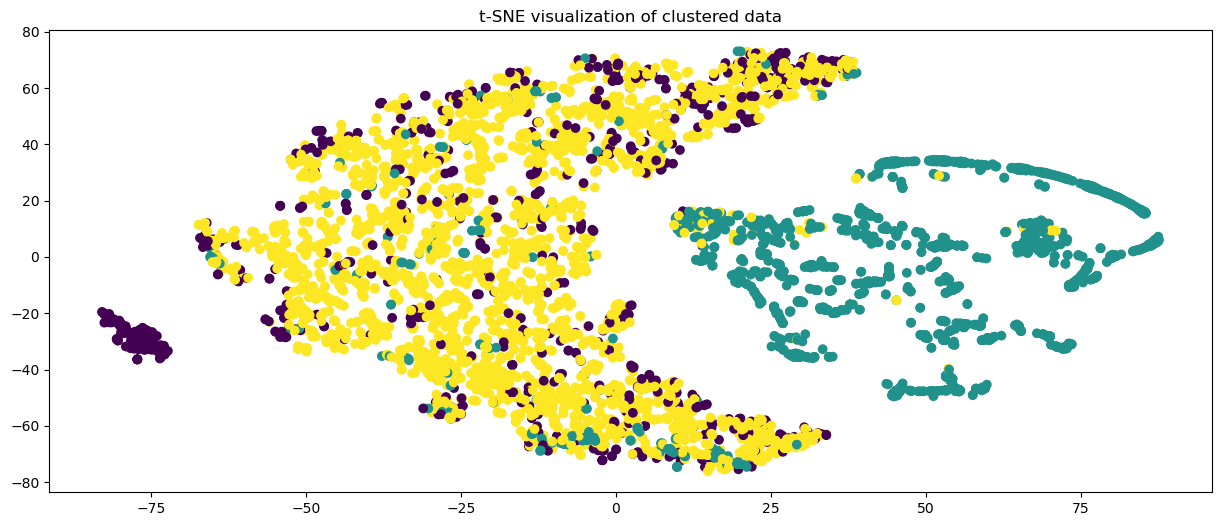

In [63]:
''' Visualizing the Clusters '''

dec.eval()
with torch.no_grad():
    _, z= dec(X_tensor.to(device)) # Get embedded features
    # Reduce dimensions for visualization (using t-SNE)
    z_2d = TSNE(n_components=2).fit_transform(z.cpu().numpy())

    # Visualize the clusters (color = cluster assignments)
    plt.figure(figsize=(15,6))
    plt.scatter(z_2d[:,0], z_2d[:,1], c=cluster_ids, cmap='viridis')
    plt.title('t-SNE visualization of clustered data')
    plt.show()

In [64]:
dec.eval()

''' Assign each data point to a cluster (hard assignment) '''
with torch.no_grad():
    q, _ = dec(X_tensor.to(device))
    preds = torch.argmax(q, dim=1).cpu().numpy()

''' Add cluster labels to original dataframe '''
df_train = df.iloc[-X_tensor.shape[0]:].copy()
df_train['cluster_id'] = preds

In [65]:
cluster_summary = df_train.groupby('cluster_id').mean(numeric_only=True)
print(cluster_summary)

            jobma_catcher_id  org_type  jobma_catcher_type  is_premium  \
cluster_id                                                               
0                9161.507246  0.376812            0.992754    0.108696   
1                6910.890568  0.103386            0.002418    0.004837   
2                6355.718779  0.136216            0.950509    0.222710   

            jobma_catcher_sub_accounts  jobma_verified  subscription_status  \
cluster_id                                                                    
0                                  0.0        1.000000             1.195652   
1                                  0.0        0.998791             0.999395   
2                                  0.0        1.000000             1.768039   

            interview_rate  live_interview_credit  pre_recorded_credit  ...  \
cluster_id                                                              ...   
0                      0.0               1.326087            90.065145  ...

# Final Step: Add Meaningful Cluster Labels for Recommendation System

In [67]:
cluster_names = {
    0: "Passive",   # Average
    1: "Engaged",   # Active
    2: "Dormant",   # Very Low Activity
    3: "Loyal"      # Very High Activity
}
df_train['cluster_label'] = df_train['cluster_id'].map(cluster_names)

In [68]:
type(df_train)

pandas.core.frame.DataFrame

In [69]:
df_train.shape

(6116, 32)

In [70]:
df_train.columns

Index(['jobma_catcher_id', 'org_type', 'jobma_catcher_industry',
       'jobma_catcher_type', 'is_premium', 'jobma_catcher_sub_accounts',
       'jobma_catcher_is_deleted', 'jobma_verified', 'subscription_status',
       'interview_rate', 'live_interview_credit', 'pre_recorded_credit',
       'credit_value', 'interview_cost_type', 'subscription_type_x',
       'jobma_support_rtc', 'interview_question', 'video_recording_suppport',
       'sing_up_canditate_after_apply', 'currency', 'company_size',
       'wallet_amount', 'plan_type', 'is_unlimited', 'premium_storage',
       'subscription_amount', 'number_of_subscriptions',
       'number_of_invitations', 'job_posted', 'number_of_kits', 'cluster_id',
       'cluster_label'],
      dtype='object')

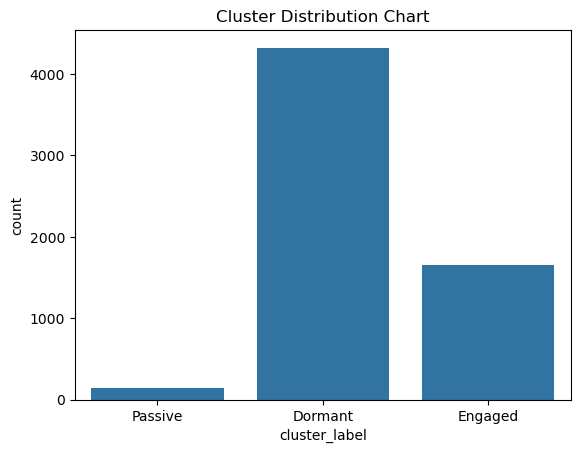

In [71]:
''' Visualizing the Cluster as a chart to determine the distribution of labels '''

sns.countplot(x='cluster_label', data=df_train)
plt.title('Cluster Distribution Chart')
plt.show()

# Recommendation System

In [73]:
original_df = pd.read_csv('recommend1.csv')

In [74]:
df_train.columns

Index(['jobma_catcher_id', 'org_type', 'jobma_catcher_industry',
       'jobma_catcher_type', 'is_premium', 'jobma_catcher_sub_accounts',
       'jobma_catcher_is_deleted', 'jobma_verified', 'subscription_status',
       'interview_rate', 'live_interview_credit', 'pre_recorded_credit',
       'credit_value', 'interview_cost_type', 'subscription_type_x',
       'jobma_support_rtc', 'interview_question', 'video_recording_suppport',
       'sing_up_canditate_after_apply', 'currency', 'company_size',
       'wallet_amount', 'plan_type', 'is_unlimited', 'premium_storage',
       'subscription_amount', 'number_of_subscriptions',
       'number_of_invitations', 'job_posted', 'number_of_kits', 'cluster_id',
       'cluster_label'],
      dtype='object')

In [75]:
original_df.columns

Index(['jobma_catcher_id', 'jobma_catcher_company', 'company_size',
       'is_premium'],
      dtype='object')

In [76]:
def recommend(df, original_df, metric='wallet_amount', top_k=5, label='Loyal'):
    loyal_df = df[df['cluster_label'] == label]
    top_clients_df = loyal_df.sort_values(by=metric, ascending=False).head(top_k)
    merged_df = pd.merge(top_clients_df,
                         original_df[['jobma_catcher_id', 'jobma_catcher_company', 'company_size', 'is_premium']], 
                         on='jobma_catcher_id', 
                         how='left', 
                         suffixes=('_train', '_orig'))

    # columns_to_return = [col for col in ['jobma_catcher_id', 'jobma_catcher_company', 'company_size', 'is_premium'] if col in merged_df.columns]
    
    
    return merged_df[[
        'jobma_catcher_id',
        'jobma_catcher_company',
        'company_size_orig',
        'is_premium_orig'
    ]].rename(columns={
        'company_size_orig': 'company_size',
        'is_premium_orig'  : 'is_premium'
    })

In [77]:
original_df.columns

Index(['jobma_catcher_id', 'jobma_catcher_company', 'company_size',
       'is_premium'],
      dtype='object')

In [78]:
''' Loyal '''

result_loyal = recommend(df_train, original_df, metric='wallet_amount', top_k=5, label='Loyal')
print(result_loyal)

Empty DataFrame
Columns: [jobma_catcher_id, jobma_catcher_company, company_size, is_premium]
Index: []


In [79]:
''' Engaged '''

result_engaged = recommend(df_train, original_df, metric='wallet_amount', top_k=5, label='Engaged')
print(result_engaged)

   jobma_catcher_id jobma_catcher_company company_size  is_premium
0              5465                   ssi       26-100         0.0
1              5466                   ssi         1-25         0.0
2              3982                select      101-500         1.0
3              3831                   SSI         1-25         1.0
4              8292                 Jobma      101-500         0.0


In [80]:
''' Passive '''

result_passive = recommend(df_train, original_df, metric='wallet_amount', top_k=5, label='Passive')
print(result_passive)

   jobma_catcher_id jobma_catcher_company    company_size  is_premium
0              7099                qwerty            1-25         0.0
1              9577   Soyo NRI Enterprise         101-500         1.0
2             10099                  Test          26-100         0.0
3             10076         Mirja Dessert  More than 1000         0.0
4             10078                 Jobma            1-25         0.0


In [81]:
''' Dormant '''

result_dormant = recommend(df_train, original_df, metric='wallet_amount', top_k=5, label='Dormant')
print(result_dormant)

   jobma_catcher_id jobma_catcher_company    company_size  is_premium
0              9990                   SSI            1-25         0.0
1              9863                 Ankit            1-25         1.0
2              7810         apple company  More than 1000         1.0
3              8535                 sdknj            1-25         1.0
4              8636          Sri infotech          26-100         1.0
